<a href="https://colab.research.google.com/github/shreya-bhootda/Car-Brand-Analysis-By-Scraping-Edmunds-Data/blob/main/Assignment%201%20Edmunds%20Forum%20Scrape%20and%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Analytics for Unstructured Data 
## <center> Group Assignment - 1
## <center> Edmunds Forum 

**Group Members:** <br>

- Shreya Bhootda (sb58653)<br>
- Rohitashwa Chakraborty (rc47878) <br>
- Sukeerth Cheruvu (sc63232) <br>
- Dipali Pandey (dp33957) <br>
- Sahitya Sundar Raj Vijayanagar (sv25849) <br>

**Link Used:** https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

**Comment Pages Scraped:** Pg.323 - Pg.436



In [1]:
# Use this code if using Colab to run Selenium
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

     |████████████████████████████████| 904 kB 4.2 MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.4 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:14 http://archive.

In [2]:
from selenium import webdriver 

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler

comments_5000 = pd.DataFrame(columns = ['Date','user_id','comments']) 

# SCRAPING LATEST COMMENTS FROM EDMUNDS FORUM


In [4]:
driver = webdriver.Chrome('chromedriver',options=chrome_options)

In [5]:
size = 5000
pages = (int)((size*1.1/50)+1) + 1
print("Pages to scrape:",pages)

Pages to scrape: 112


In [6]:
print("Scraping Pages:",435-pages,"to",436)


for i in tqdm(range(436,435-pages,-1)):
    comment_url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}".format(i)
    driver.get(comment_url)
    ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
    for j in ids:
        x = j.get_attribute('id')
        #Extract dates from for each user on a page
        user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
        date = user_date.get_attribute('title')

        #Extract user ids from each user on a page
        userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
        userid = userid_element.text

        #Extract Message for each user on a page
        user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
        comment = user_message.text
        # print("Comment:\n",comment)

        # Check if message is a reply; omit reply
        try:
            message_reply = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]/blockquote')[0]
            reply = message_reply.text
            comment = comment.replace(reply,"")
        except:
            ;
        
        #Adding date, userid and comment for each user in a dataframe    
        comments_5000.loc[len(comments_5000)] = [date,userid,comment]

Scraping Pages: 323 to 436


100%|██████████| 113/113 [14:02<00:00,  7.46s/it]


In [103]:
driver.close()
comments = comments_5000.copy()
comments = comments[comments['comments'].str.len()!=0].reset_index()
comments["comments"] = comments["comments"].str.lower().str.strip()
comments = comments[0:size]
comments = comments[['Date','comments']]
print(comments.shape)
comments

(5000, 2)


,Date,comments
0,"February 25, 2020 12:38PM","and, that's on top of any discount you negotia..."
1,"February 25, 2020 12:41PM",add $350 to any lease on a kia if you are not ...
2,"February 25, 2020 12:44PM",did you hear about the key fob scam the dealer...
3,"February 25, 2020 12:47PM",that's a jaw-dropping lease incentive. amazing...
4,"February 25, 2020 12:50PM",i'm pretty sure that's the case with any capti...
...,...,...
4995,"March 18, 2014 6:48PM",wow these message boards are dormant -
4996,"March 18, 2014 8:03PM",we're all out driving or test-driving.
4997,"March 23, 2014 6:47PM",i guess or format still not taking hold-\n\nfo...
4998,"March 23, 2014 6:47PM",pix


In [106]:
comments.to_csv("comments_{a}.csv".format(a = size), index = False)

***
# PART A _(Zipf's Law)_

*   Used nltk to tokenize the comment and stored it in a seperate column
*   Iterated over the comments to create a dictionary which stores the  word and corresponding frequencies
*   Sorted the dictionary and found the top 100 frequent words
Plotted the log
* Plotted the log(rank) vs log(frequency) graph.


In [107]:
df = pd.read_csv('comments_5000.csv')
df['comments'] = df['comments'].astype('string')
df.head(5)

,Date,comments
0,"February 25, 2020 12:38PM","and, that's on top of any discount you negotia..."
1,"February 25, 2020 12:41PM",add $350 to any lease on a kia if you are not ...
2,"February 25, 2020 12:44PM",did you hear about the key fob scam the dealer...
3,"February 25, 2020 12:47PM",that's a jaw-dropping lease incentive. amazing...
4,"February 25, 2020 12:50PM",i'm pretty sure that's the case with any capti...


In [108]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [109]:
df['comments'] = df['comments'].astype('string')
df['Tokens'] = df['comments'].apply(nltk.tokenize.word_tokenize)
df.head(5)

,Date,comments,Tokens
0,"February 25, 2020 12:38PM","and, that's on top of any discount you negotia...","[and, ,, that, 's, on, top, of, any, discount,..."
1,"February 25, 2020 12:41PM",add $350 to any lease on a kia if you are not ...,"[add, $, 350, to, any, lease, on, a, kia, if, ..."
2,"February 25, 2020 12:44PM",did you hear about the key fob scam the dealer...,"[did, you, hear, about, the, key, fob, scam, t..."
3,"February 25, 2020 12:47PM",that's a jaw-dropping lease incentive. amazing...,"[that, 's, a, jaw-dropping, lease, incentive, ..."
4,"February 25, 2020 12:50PM",i'm pretty sure that's the case with any capti...,"[i, 'm, pretty, sure, that, 's, the, case, wit..."


In [12]:
word_dict=dict()

for row in df['Tokens']:
    for word in row:
        if word.lower() in word_dict:
            word_dict[word.lower()] += 1
        else:
            word_dict[word.lower()] = 1
list_orderd = []
sort_word_dict = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)


In [13]:
x = []
y = []
count = 1
for k, v in sort_word_dict:
    if count<=100:
        x.append(v)
        y.append(count)
        count+=1
        

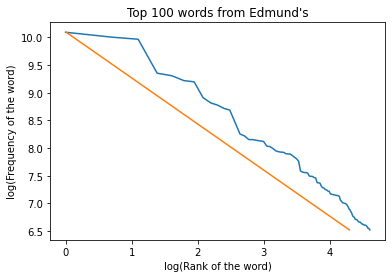

In [14]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.log(y),np.log(x))
plt.plot(12*(1.01 - 0.1*np.log(x)),np.log(x))
plt.title("Top 100 words from Edmund's")
plt.xlabel("log(Rank of the word)")
plt.ylabel("log(Frequency of the word)");
plt.show()

***
# PART B _(Replacing Model Names by corresponding Brand Names)_

*   Stored the models to brand mapping csv in a dataframe
*   Filtered the df and converted it to lower case
*   Replaced models with with brands in the comments dataframe
*   Updated the word frequency dictionary (models converted to brands)
*   Sorted the brands by frequency of mention and found the top 10 most talked about brands









In [15]:
models = pd.read_csv('car_models.csv')
models['Brand'] = models['Brand'].astype('string')
models['Model'] = models['Model'].astype('string')
models['Model'].apply(str.lower)
models['Brand'].apply(str.lower)
models = models[(models.Brand != 'mercedes benz') & (models.Brand != 'mercedes-benz')]
models.head(5)

,Brand,Model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx


In [16]:
def remove_models_from_df(row):
  cleaned_row = []
  row_list = row.split()  
  for word in row_list:
    #print(word)
    if word.lower() in models['Model'].to_list():
      
      word = models['Brand'][models['Model']==word.lower()].to_list()[0]
      
    cleaned_row.append(word)
  return ' '.join(cleaned_row).strip()

df_copy = df.copy()
comments['comments'] = df_copy['comments'].apply(remove_models_from_df)
comments['comments']

0       and, that's on top of any discount you negotia...
1       add $350 to any lease on a kia if you are not ...
2       did you hear about the key fob scam the dealer...
3       that's a jaw-dropping lease incentive. amazing...
4       i'm pretty sure that's the case with any capti...
                              ...                        
4995               wow these message boards are dormant -
4996               we're all out driving or test-driving.
4997    i guess or format still not taking hold- for t...
4998                                                  pix
4999    @sweendogy i see you hate your state's front p...
Name: comments, Length: 5000, dtype: object

In [44]:
def removing_models(x):
    if str(x['Model']) in word_dict_copy.keys():
       
        if str(x['Brand']) in word_dict_copy.keys():  
             
             word_dict_copy[x['Brand']] = word_dict_copy[x['Brand']]+word_dict_copy[x['Model']]
             
             del word_dict_copy[x['Model']]
        else:
             word_dict[x['Brand']] = word_dict[x['Model']]                                  

word_dict_copy = word_dict.copy()                                               
models.apply(removing_models, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
525    None
526    None
527    None
528    None
529    None
Length: 528, dtype: object

In [45]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

for word in stop_words:
    if word in word_dict_copy.keys():
        del word_dict_copy[word]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
brands = pd.DataFrame.from_dict(word_dict_copy, orient='index', columns = ['Count'])
brands = brands[brands.index.isin(models['Brand'])]
brands.sort_values(by='Count', ascending=False, inplace=True)
brands[:15]

,Count
car,4348
audi,2106
bmw,1947
acura,1026
honda,782
seat,492
volkswagen,469
cadillac,386
infiniti,366
mercedes,342


***
# PART C _(Lift calculations between top 10 brands)_

*   Calculate number of comments in which each of the top brands occur
*   Calculate number of comments in which pairs of the top brands occur
*   Calculate the lift between the pairs as follows:

$$ \text{Lift(A,B)}  = \frac{P(A,B)}{P(A) \times P(B)}$$

$$ \text{or, Lift(A,B)}  = \frac{N \times \text{#}(A,B)}{\text{#}A \times \text{#}B}$$

_The latter is the formula we have used in this script_

In [47]:
top_brands = list(brands[:15].index).copy()
top_brands.remove('car')
top_brands.remove('sedan')
top_brands.remove('problem')
top_brands.remove('seat')
top_brands = top_brands[:10]
pd.DataFrame(top_brands,columns=['Top 10 Brands'])

,Top 10 Brands
0,audi
1,bmw
2,acura
3,honda
4,volkswagen
5,cadillac
6,infiniti
7,mercedes
8,hyundai
9,toyota


In [48]:
freq = np.zeros(len(top_brands))
brand_frequency = {k:v for k,v in zip(top_brands,freq)}

In [49]:
def count_freq_1(s,key):
  
  ''' Return 1 if brandname occurs in comment, else return 0'''
  if key.lower() in str(s).lower():
    return 1
  else:
    return 0

for key in brand_frequency.keys():
  count = 0
  count += comments['comments'].apply(count_freq_1,args=(key,))
  brand_frequency[key] = count.value_counts()[1]

pd.DataFrame.from_dict(brand_frequency, orient='index', columns=['Frequency'])

,Frequency
audi,827
bmw,1025
acura,517
honda,368
volkswagen,215
cadillac,225
infiniti,229
mercedes,211
hyundai,169
toyota,164


In [50]:
res = [(a, b) for idx, a in enumerate(top_brands) for b in top_brands[idx + 1:]]
freq = np.zeros(len(res))

cooccurence = {k:v for k,v in zip(res,freq)}

In [51]:
def count_freq_2(s,key1,key2):

  ''' Return 1 if both brandname key1 and key2 occur in comment, else return 0'''

  if (key1.lower() in str(s).lower()) and (key2.lower() in str(s).lower()):
    return 1
  else:
    return 0

for key1,key2 in cooccurence.keys():
  count = 0
  count += comments['comments'].apply(count_freq_2,args=(key1,key2))
  cooccurence[(key1,key2)] = 5000-count.value_counts()[0]

pd.DataFrame.from_dict(cooccurence, orient='index', columns=['Frequency']).head()

,Frequency
"(audi, bmw)",348
"(audi, acura)",185
"(audi, honda)",107
"(audi, volkswagen)",89
"(audi, cadillac)",111


In [52]:
lifts_table = pd.DataFrame(columns = top_brands,
                   index = top_brands)

number_of_comments = 5000

for i in lifts_table.index:
  for j in lifts_table.columns:
    if (i,j) in cooccurence:
      lifts_table[j][i] = (number_of_comments * cooccurence[(i,j)])/(brand_frequency[i]*brand_frequency[j])
      lifts_table[i][j] = (number_of_comments * cooccurence[(i,j)])/(brand_frequency[i]*brand_frequency[j])
    else:
      continue

lifts_table

,audi,bmw,acura,honda,volkswagen,cadillac,infiniti,mercedes,hyundai,toyota
audi,NaN,2.05267,2.16344,1.75793,2.50274,2.98267,2.95697,3.69634,1.82452,1.84328
bmw,2.05267,NaN,1.56626,1.11347,1.2025,2.10298,2.17276,3.30598,1.44321,1.45747
acura,2.16344,1.56626,NaN,3.94206,1.2595,2.75091,4.39215,3.20845,2.11736,1.65118
honda,1.75793,1.11347,3.94206,NaN,2.02224,1.50966,2.19527,1.8674,2.41189,3.39674
volkswagen,2.50274,1.2025,1.2595,2.02224,NaN,1.13695,1.62486,1.76347,2.33934,2.55247
cadillac,2.98267,2.10298,2.75091,1.50966,1.13695,NaN,3.59049,5.16061,2.36686,2.16802
infiniti,2.95697,2.17276,4.39215,2.19527,1.62486,3.59049,NaN,5.27743,2.8423,2.52956
mercedes,3.69634,3.30598,3.20845,1.8674,1.76347,5.16061,5.27743,NaN,2.66412,2.31187
hyundai,1.82452,1.44321,2.11736,2.41189,2.33934,2.36686,2.8423,2.66412,NaN,3.78843
toyota,1.84328,1.45747,1.65118,3.39674,2.55247,2.16802,2.52956,2.31187,3.78843,NaN


In [53]:
lifts_table.to_csv('Lifts.csv')

***
# PART D _(MDS Plot for based on lifts for top 10 brands)_

In [54]:
df = pd.read_csv('Lifts.csv',index_col=0)
df =df.fillna(0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df)

In [55]:
mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(X_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


In [56]:
X_2d

array([[-0.17658576,  0.3407384 ],
       [ 0.15563855, -0.16792535],
       [-0.01344372, -0.77589335],
       [-0.53977901,  0.6605336 ],
       [ 0.53013327, -0.6762101 ],
       [ 0.67396971, -0.11103836],
       [ 0.20805392,  0.96661496],
       [-0.96357196, -0.73389873],
       [-0.70339386,  0.07558132],
       [ 0.82897886,  0.42149761]])

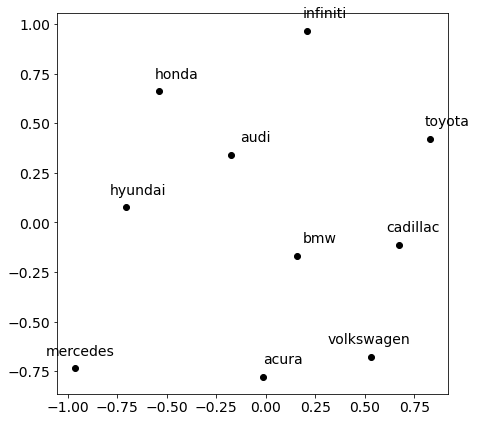

In [57]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

x= X_2d[:,0]
y= X_2d[:,1]

for i in range(len(x)):
  plt.scatter(x[i],y[i],c='black')
  plt.annotate(
        df.index.values[i],
        xy = (x[i], y[i]), xytext = (40, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom')
plt.show()

***
# PART E _(Insights based on Part C and Part D)_

Insights based on lift values and MDS plot:


1.    All the lift values are more than 1 indicating that association between any pair of brands has occurred not just by a chance. 
2.    The highest values of lifts have been identified between **Mercedes** and **Infiniti**, **Mercedes** and **Cadillac**. All three of these brands are _luxury_ ones and have comparable models.
3.    Lowest lift values have been observed between **Honda** and **BMW**, **Volkswagen** and **Cadillac**. **BMW**, **Cadillac** are luxury brands whereas **Volkswagen** and **Honda** are not. Hence, not a lot of comparisons have been made in the forum resulting in low lift values.
4.    Out of the top 10 brands, 6 are _luxury_ brands. It indicates that the forum users mostly talked about the features of luxury brands and compared their features with other brands such as _Toyota, Volkswagen, Honda,_ and _Hyundai_.
5.    In the MDS plot, _Honda_ and _Hyundai_ are closer to each other and also to _Audi_. High end models of _Honda_ and _Hyundai_ are comparable to Low end models of _Audi_ such as A4.
6.    The non-luxury brands are spread across the scatterplot towards the boundaries around the luxury brands. This also shows brand perceptions and how consumers view non-luxury brands amongst luxury brands


***
# PART F _(Lifts between Top brands and Top 5 properties)_

Identifying top 5 properties:


1.   Using the word frequency calculated in part A for Zipf's law, we manually checked the top 100 frequently occuring words.
2.   Based on the search, we found the following 5 properties to be talked about the most in comments: **Performance, Power, Luxury, Engine, Price**



In [58]:
top_properties = ['performance','power','luxury','engine','price']
freq_p = np.zeros(len(top_properties))
pd.DataFrame(top_properties,columns=['Top 5 Properties'])

,Top 5 Properties
0,performance
1,power
2,luxury
3,engine
4,price


In [59]:
property_frequency = {k:v for k,v in zip(top_properties,freq_p)}

In [60]:
for key in property_frequency.keys():
  count = 0
  count += comments['comments'].apply(count_freq_1,args=(key,))
  property_frequency[key] = count.value_counts()[1] 

In [61]:
pd.DataFrame.from_dict(brand_frequency, orient='index', columns=['Frequency'])

,Frequency
audi,827
bmw,1025
acura,517
honda,368
volkswagen,215
cadillac,225
infiniti,229
mercedes,211
hyundai,169
toyota,164


In [62]:
pd.DataFrame.from_dict(property_frequency, orient='index', columns=['Frequency'])

,Frequency
performance,316
power,322
luxury,285
engine,436
price,577


In [63]:
import itertools
res = list(itertools.product(top_brands, top_properties))

In [64]:
cooccurence = {k:v for k,v in zip(res,np.zeros(len(res)))} 

In [65]:
for key1,key2 in cooccurence.keys():
  count = 0
  count += comments['comments'].apply(count_freq_2,args=(key1,key2))
  cooccurence[(key1,key2)] = 5000-count.value_counts()[0]

pd.DataFrame.from_dict(cooccurence, orient='index', columns=['Frequency']).head()

,Frequency
"(audi, performance)",117
"(audi, power)",110
"(audi, luxury)",102
"(audi, engine)",145
"(audi, price)",174


In [66]:
lifts_table = pd.DataFrame(columns = top_brands,
                   index = top_properties)

number_of_comments = 5000
for i in lifts_table.index:
  for j in lifts_table.columns:
    if (j,i) in cooccurence:
      lifts_table.loc[i][j] = (number_of_comments * cooccurence[(j,i)])/(property_frequency[i]*brand_frequency[j])
    else:
      continue

lifts_table

,audi,bmw,acura,honda,volkswagen,cadillac,infiniti,mercedes,hyundai,toyota
performance,2.23853,1.83699,2.01993,1.63387,1.69267,2.25035,2.41833,2.8496,1.31076,1.73665
power,2.06539,1.71186,1.92222,2.02538,1.95002,1.38026,1.35615,1.69262,1.74575,1.89365
luxury,2.16381,1.76294,2.54505,2.00229,1.38719,3.4308,2.91121,3.409,2.90667,1.49765
engine,2.01069,1.62229,1.9298,1.8386,2.08022,1.37615,1.80281,1.68486,1.69643,1.46845
price,1.82322,1.87682,1.67611,1.67188,1.41066,2.5804,1.58931,2.42306,2.15356,1.69083


***
# Part G _(Insights based on Part F)_

Insights based on lift calculation between top 10 brands and top 5 properties, assuming that all associations are positive:


1. We see that all lift values are >1, meaning that the association between the brands and the properties has not occurred by chance
2. Since all the associations are positive, the consumers have positively spoken about these brands in the context of the properties identified
3. With respect to **performance**, we observe that _Mercededs_ and _Infiniti_ are popularly considered to be top performers. 
4. It is surprising to see that motorsport powerhouses like _Audi_, _Hyundai_ and _Honda_, despite being superior in terms of technology and  **performance**, do not enjoy the same reception by the people, who favour brands like _Cadillac_.
5. Conglomerates like **Volkswagen Group** has done a reasonably good job segregating their product lines as _Audi_ is clearly perceived as a superior brand than _Volkswagen_ in terms of _Luxury_, _Power_ and _Performance_. 
6. Our analysis reconciles with the popular notion that brands like _Audi_ and _Honda_ have highly efficient **power** units and transmission.
7. Cadillac seems to be the most **luxurious** brand, followed by Mercedes. However, we see that other brands that are generally branded as luxurious, like Audi and BMW, perform poorly when compared to the likes of Infiniti, Hyundai, and Honda, probably indicating that people find top models of these brands to be more luxurious when compared to Audi and BMW 
8. German engineering reigns supreme as _Volkswagen_ and _Audi_ dominate **Engine** performance. These brands are closely followed by _Acura_ and _Honda_, which are both owned by the Japanese Manufacturer _Honda_.
9. Cadillac and Mercedes perform best in terms of **price** or being most cost effective



***
# Part H _(Identifying most aspirational brands)_

In [82]:
import re
posts=comments.copy()
posts2=posts["comments"]
posts2=posts2[posts2.notnull()]

brand_model = pd.read_csv('car_models.csv')

s_brand=brand_model['Brand'].map(lambda x:x.lower())
s_brand=s_brand.map(lambda x:x.replace('.','').replace(',','').replace('-',' '))
s_model=brand_model['Model'].map(lambda x:x.lower())
s_model=s_model.map(lambda x:x.replace('?',''))

In [85]:
import re
post_converted=posts2.map(lambda x:x.lower())

for i,m in enumerate(s_model):
    post_converted=post_converted.map(lambda x:re.sub(str(m), s_brand[i],str(x)))

In [86]:
brands=s_brand.unique()
brands

array(['acura', 'audi', 'bmw', 'buick', 'cadillac', 'car', 'chevrolet',
       'chrysler', 'dodge', 'ford', 'honda', 'hyndai kia', 'hyundai',
       'infiniti', 'kia', 'lincoln', 'mazda', 'mercedes', 'mercedes benz',
       'mercury', 'mitsubishi', 'nissan', 'pontiac', 'problem', 'saturn',
       'seat', 'sedan', 'subaru', 'suzuki', 'toyata', 'toyota',
       'volkswagen', 'volkwagen', 'volvo'], dtype=object)

In [87]:
#getting the final list of car brands to look at
brands_edited=['acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet',
       'chrysler', 'dodge', 'ford', 'honda', 'hyundai kia', 'hyundai',
       'infiniti', 'kia', 'lincoln', 'mazda', 'mercedes',
       'mercury', 'mitsubishi', 'nissan', 'pontiac', 'saturn',
       'seat', 'subaru', 'suzuki', 'toyota',
       'volkswagen', 'volvo']
brands=brands_edited

In [88]:
#remove punctuations from the text
def remove_punctuation(text):
    '''remove punctuations and add a space before and after each brand name'''
    punctuation=['.',',',';',':','\\','?','(',')','-','"','/','\'s']
    for p in punctuation:
        text=text.replace(p,' ')
    for brand in brands:
        text=text.replace(brand,' '+brand+' ')
    return text

posts_nopunct=post_converted.map(lambda x:remove_punctuation(str(x)))

In [89]:
# Check if a brand is in the text
def get_idx(brand, text): 
    '''check if a brand is in a post first,
    find the index of a brand in a post
        '''
    totalcount=len(re.findall(brand,text))
    token=text.split()
    temp_idx = token.index(brand)
    idx=temp_idx
    idx_list=[idx]
    count=1
    while idx<len(token) and count<totalcount:
        temp_idx = token[idx+1:].index(brand)
        idx=idx+temp_idx+1
        idx_list.append(idx) 
        count+=1
    return idx_list

In [90]:
# Get the index of a brand in a post and get the +5 and -5 words from that index
def feature(brand,text):
    '''use get_idx function to get the index of a brand in a post,
    and then take +5 and -5 words based on these indexes'''
    idx_list=get_idx(brand,text)
    token=text.split()
    feature_list=[]
    for i in idx_list:
        feature_list=feature_list+token[max(0,i-5):i]+token[i+1:min(i+6,len(token))]
    return feature_list

In [91]:
#filter1 and filter2 have the aspirational bigram combinations
filter1 = ['love','hope','want','wish','dream','desire','crave','wanted','always', 'want', 'like', 'kill', 'future', 'aspire']
filter2 = ['to','have','car','it','of','this', 'love', 'machine', 'always', 'for']

filter_set1 = set(filter1)
filter_set2 = set(filter2)

# Return the occurence of aspirational bigrams for every brand
def find(brand,text):
    bigram_list = []
    if(brand in text):
        f=feature(brand,text)     
        bigram = list(zip(*[f[i:] for i in range(2)]))
        for i,j in enumerate(bigram):
                if(len(j) != 0):
                     if((j[0] in filter_set1) & (j[1] in filter_set2)):
                      #if
                         bigram_list.append(j)
        return len(bigram_list)

In [92]:
asp_brand = {}
for brand in brands:
    asp_brand[brand] = posts_nopunct.map(lambda x: find(brand,x))

In [93]:
# create a dataframe to calculate number of posts with aspirations for every brand and number of posts with aspirations
asp_table = pd.DataFrame(columns = brands)
for brand in brands:
    asp_table[brand]=asp_brand[brand]
asp_table2 = asp_table.fillna(0)

asp_entries = asp_table2.sum(axis=1)
asp_brand2 = asp_table2[asp_table2 > 0].count(axis = 0)
no_asp = 0
for i in asp_entries.iteritems():
    if(i[1]>0):
        no_asp +=1

In [94]:
# Calculate the number of posts with brands mentioned and create a dataframe with required values to calculate lift
import math 

bcount = []
aspiration = pd.DataFrame(columns=['brand','asp_bcount','brand_occurence'])
aspiration['brand'] = brands
for brand in brands:
    count = 0
    for i in asp_table[brand].iteritems():
        if(i[1] is not None):
            if(math.isnan(i[1]) == False):
                count = count + 1
    bcount.append(count)
aspiration['asp_bcount'] = asp_brand2.values
aspiration['brand_occurence'] = bcount

In [95]:
#Calculate lift for each brand = (n(posts with brand & aspiration)*len(posts))/(n(posts with aspirations)*n(posts with brand))
aspiration['lift'] = (aspiration['asp_bcount']*len(posts_nopunct))/(no_asp * aspiration['brand_occurence'])
print("Top 5 Aspirational Brands:")
aspiration.sort_values(by='lift',ascending=False).iloc[:5]

Top 5 Aspirational Brands:


,brand,asp_bcount,brand_occurence,lift
5,chevrolet,5,157,1.460878
16,mercedes,6,236,1.166226
25,toyota,23,1195,0.882884
1,audi,17,944,0.826077
4,cadillac,4,228,0.804764


- The most aspirational brand as per latest 5000 comments on Edmunds appears to be Chevrolet followed by Mercedes, Toyota, Audi and then Cadillac. Various combinations of bigrams were used for this analysis and lift values of the brand names were calculated against these bigrams. 


- When trying to find out what features make these brands aspirational (see below analysis), it was seen that performance and price had the highest lift values with Chevrolet and luxury and performance with Mercedes. 


- Chevrolet, Mercedes and other top aspirational brands must leverage this image associated with them and target the customers writing these comments and other similar individuals. They should come up with campaigns enticing these prospective customers with right kind of deals and offers via appropriate touchpoints using effective channels.



In [96]:
aspirational_brands = ['chevrolet','mercedes','toyota','audi','cadillac']
freq_ab = np.zeros(len(aspirational_brands))
asp_brand_frequency = {k:v for k,v in zip(aspirational_brands,freq_ab)}
asp_brand_frequency

{'audi': 0.0,
 'cadillac': 0.0,
 'chevrolet': 0.0,
 'mercedes': 0.0,
 'toyota': 0.0}

In [97]:
for key in asp_brand_frequency.keys():
  count = 0
  count += comments['comments'].apply(count_freq_1,args=(key,))
  asp_brand_frequency[key] = count.value_counts()[1]

pd.DataFrame.from_dict(asp_brand_frequency, orient='index', columns=['Frequency'])

,Frequency
chevrolet,97
mercedes,211
toyota,164
audi,827
cadillac,225


In [98]:
pd.DataFrame.from_dict(property_frequency, orient='index', columns=['Frequency'])

,Frequency
performance,316
power,322
luxury,285
engine,436
price,577


In [99]:
import itertools
res = list(itertools.product(aspirational_brands, top_properties))

In [100]:
cooccurence = {k:v for k,v in zip(res,np.zeros(len(res)))} 

In [101]:
for key1,key2 in cooccurence.keys():
  count = 0
  count += comments['comments'].apply(count_freq_2,args=(key1,key2))
  cooccurence[(key1,key2)] = 5000-count.value_counts()[0]

pd.DataFrame.from_dict(cooccurence, orient='index', columns=['Frequency']).head()

,Frequency
"(chevrolet, performance)",16
"(chevrolet, power)",14
"(chevrolet, luxury)",11
"(chevrolet, engine)",14
"(chevrolet, price)",27


In [102]:
lifts_table = pd.DataFrame(columns = aspirational_brands,
                   index = top_properties)

number_of_comments = 5000
for i in lifts_table.index:
  for j in lifts_table.columns:
    if (j,i) in cooccurence:
      lifts_table.loc[i][j] = (number_of_comments * cooccurence[(j,i)])/(property_frequency[i]*asp_brand_frequency[j])
    else:
      continue

lifts_table

,chevrolet,mercedes,toyota,audi,cadillac
performance,2.60994,2.8496,1.73665,2.23853,2.25035
power,2.24115,1.69262,1.89365,2.06539,1.38026
luxury,1.98951,3.409,1.49765,2.16381,3.4308
engine,1.65516,1.68486,1.46845,2.01069,1.37615
price,2.41205,2.42306,1.69083,1.82322,2.5804


***
***